# REDO SOLARIS, VANDENBERGH, PISKUNOV, KHARCHENKO

# Read in all the files, and make some plots

*Andrew Bowen provided much of the script to read in the file. [See his GitHub repo](https://github.com/andrewbowen19/CEB_Project)*

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import sys

import csv

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#MWSC - Milky Way Star Clusters Catalog
#https://heasarc.gsfc.nasa.gov/W3Browse/all/mwsc.html

mwsc_df = pd.read_csv("MWSC.txt", header=3, delimiter='|')
mwsc_df.columns = mwsc_df.columns.str.strip()

#fix the IDs
mwsc_ID = mwsc_df['name']
mwsc_ID = mwsc_ID.str.strip().str.replace( ' ','_' )
mwsc_df['name'] = mwsc_ID

#take only the open clusters
mwsc_df = mwsc_df.loc[(~mwsc_df['class'].str.strip().str.contains('GLOBULAR')) &
                      (~mwsc_df['class'].str.strip().str.contains('NEBULA')) &
                      (~mwsc_df['class'].str.strip().str.contains('UNIDENTIFIED'))]

print(set(mwsc_df['class'].values))
mwsc_df

{'                                  OPEN STAR CLUSTER', '                          OB ASSOCIATION/HII REGION'}


,Unnamed: 0,name,broad_type,cluster_status,ra,dec,lii,bii,core_radius,central_radius,...,king_norm_factor,king_norm_factor_error,reference_code,cluster_type,metallicity,metallicity_error,num_metallicity_stars,comments,class,Unnamed: 42
0,NaN,MWSC_4688,,,23 51 54,-86 43.2,303.907,-30.295,0.020,0.100,...,2.51,0.67,AIPk,,,,0,...,OPEN STAR CL...,NaN
1,NaN,MWSC_5684,,,12 53 43,-86 38.9,302.968,-23.776,0.020,0.080,...,1.88,1.09,ARIs,,,,0,...,OPEN STAR CL...,NaN
2,NaN,MWSC_5692,,,17 47 20,-86 36.6,306.562,-26.146,0.025,0.095,...,1.51,0.77,ARIs,,,,0,...,OPEN STAR CL...,NaN
3,NaN,MWSC_4005,,,00 11 28,-85 28.8,303.852,-31.577,0.012,0.100,...,15.94,6.19,AIPk,,,,0,...,OPEN STAR CL...,NaN
4,NaN,MWSC_4176,,,14 27 18,-85 25.2,304.950,-22.929,0.025,0.150,...,6.46,1.31,AIPk,,,,0,...,OPEN STAR CL...,NaN
5,NaN,ESO_008-06,r,c,14 56 55,-83 26.7,306.593,-21.485,0.025,0.130,...,5.93,1.91,DIAS,,,,0,"Sparse; center is shifted to 14.9485h,-83.445d...",OPEN STAR CL...,NaN
6,NaN,MWSC_4219,,,15 42 14,-83 11.7,307.905,-22.041,0.015,0.115,...,1.71,0.41,AIPk,,,,0,...,OPEN STAR CL...,NaN
7,NaN,MWSC_5575,,,01 59 42,-83 03.0,300.484,-33.751,0.015,0.090,...,0.79,0.18,ARIs,,,,0,Poor RDP. ...,OPEN STAR CL...,NaN
8,NaN,MWSC_4682,,,23 43 23,-82 57.6,305.407,-33.838,0.020,0.115,...,5.33,3.02,AIPk,,,,0,...,OPEN STAR CL...,NaN
10,NaN,MWSC_5685,,,13 05 24,-82 02.6,303.443,-19.185,0.020,0.090,...,9.02,2.40,ARIs,,,,0,Poor RDP. ...,OPEN STAR CL...,NaN


### Downloaded from WEBDA [here](https://webda.physics.muni.cz/cluster_selall.html)

With RA from 0 to 24 and 0 to 1e6 stars. I copied the table to WEBDA.html, and removed the $<$br$>$ entries, then converted to csv with 

https://codepen.io/malahovks/pen/gLxLWX

or

https://jsfiddle.net/gengns/j1jm2tjx/

Finally, I separated the RA and DEC column header into 2 entries.

*I also have a data file from David James, that has more clusters, but I'm not sure the providence of that, so I won't use it.*

In [3]:
# # WEBDA data file (2013)
# webda_df = pd.read_fwf("WEBDA-OC-table-June2013_DavidJames.txt", 
#                        widths = [18,14,15,11,9,8,8,8,9,6,9,9,9,7,7,9], header = 0)

webda_df = pd.read_csv('WEBDA.csv')
#fix the IDs
webda_ID = webda_df['Cluster_name']
webda_ID = webda_ID.str.replace( 'NGC 0','NGC ' ).str.replace( ' ','_' )

webda_df['Cluster_name'] = webda_ID

webda_df

,Cluster_name,RA_2000,Dec_2000,l,b,Dist,Mod,EB-V,Age,ST,Z,Diam,Fe/H,MRV,pm RA,pm Dec,Measures,Stars
0,Berkeley_58,00 00 12,+60 58 00,116.753,-1.289,3715.0,14.55,0.550,8.400,NaN,-83.6,5.0,NaN,NaN,NaN,NaN,525,519
1,Stock_18,00 01 37,+64 37 30,117.624,2.268,2800.0,14.41,0.700,6.780,B0,110.8,6.0,NaN,NaN,NaN,NaN,2261,2261
2,Berkeley_59,00 02 13,+67 25 11,118.220,5.000,1000.0,13.78,1.220,6.800,NaN,87.2,20.4,NaN,-6.50,-4.40,0.73,27,21
3,Blanco_1,00 04 07,-29 50 00,15.572,-79.261,269.0,7.18,0.010,7.796,B5,-264.3,70.0,0.23,NaN,20.17,3.00,109,105
4,ASCC_1,00 09 35,+62 40 48,118.150,0.190,4000.0,13.51,0.160,8.250,NaN,13.3,24.0,NaN,-76.15,-2.07,0.46,32,32
5,Berkeley_1,00 09 36,+60 28 30,117.796,-1.979,2420.0,14.35,0.780,8.600,NaN,-83.6,5.0,NaN,NaN,NaN,NaN,2800,2800
6,King_13,00 10 06,+61 10 00,117.968,-1.306,3100.0,15.00,0.820,8.500,NaN,-70.7,5.0,NaN,NaN,NaN,NaN,4253,3955
7,Alessi_20,00 10 33,+58 45 35,117.640,-3.690,450.0,8.95,0.220,8.220,NaN,-29.0,36.0,NaN,NaN,7.48,-2.61,42,42
8,ASCC_2,00 19 51,+55 42 35,118.460,-6.890,1200.0,10.71,0.100,8.830,NaN,-144.0,36.0,NaN,NaN,-0.91,-3.94,57,57
9,Mayer_1,00 21 54,+61 44 24,119.440,-0.930,1429.0,12.02,0.400,7.740,NaN,-23.2,24.0,NaN,-20.90,-5.27,-5.87,15146,15131


In [4]:
#Piskunov (2008)
piskunov_df =  pd.read_csv('Piskunov2008_M.Kharchenko2013_Rhm_FeH.txt', 
                           delim_whitespace = True, header = 0)
piskunov_df

,#name,logM[Msun],rtP[pc],log(t[yr])K,rcK[pc],rtK[pc],Rhm[pc],[Fe/H]K
0,ASCC_1,3.962,36.9,8.406,0.38,5.51,1.480,99.999
1,ASCC_2,3.054,15.3,8.870,1.15,13.58,3.729,99.999
2,ASCC_3,2.789,12.8,7.729,5.80,10.54,-9.999,99.999
3,ASCC_4,2.785,12.2,8.650,0.54,2.91,0.869,99.999
4,ASCC_5,2.194,8.1,7.780,0.21,3.01,0.810,99.999
5,ASCC_6,2.866,13.5,7.800,1.40,8.47,2.499,99.999
6,ASCC_7,3.468,22.6,7.400,1.28,10.46,2.988,99.999
7,ASCC_8,3.980,34.3,7.770,1.46,11.79,3.372,99.999
8,ASCC_9,3.469,24.9,7.000,4.94,16.06,5.064,99.999
9,ASCC_10,2.496,9.9,8.717,1.46,8.95,2.636,99.999


# REDO SOLARIS, VANDENBERGH, PISKUNOV, KHARCHENKO

In [5]:
# Solaris (2014)
# Had to add last 2 column names from Van Der Bergh (2006): Diam[pc] - radius in parsecs, d[pc] = distance in parsecs
solaris_df = pd.read_csv('Solaris2004_viaWEBDA_plusvandenbergh2006_diam_dist.txt', 
                         delim_whitespace = True, header = 16)
solaris_df

,#Name,deltaV,sigdV,[FeH],sigFeH,t,sigt,logt,Rgc,z,Diam[pc],d[pc]
0,Arp-Madore_2,2.5,0.15,0.00,0.15,7.24,1.93,0.86,14.06,-740,7.76,13341.00
1,Berkeley_17,2.8,0.15,-0.33,0.15,10.06,2.77,1.00,10.89,-155,5.50,2700.00
2,Berkeley_18,2.3,0.15,0.02,0.15,5.69,1.49,0.76,12.09,325,20.25,5800.00
3,Berkeley_20,2.1,0.05,-0.61,0.15,4.05,0.69,0.61,16.12,-2420,4.89,8400.00
4,Berkeley_21,1.6,0.25,-0.97,0.15,2.18,0.78,0.34,14.27,-255,7.27,5000.00
5,Berkeley_22,2.1,0.25,-0.30,0.15,4.26,1.65,0.63,11.92,-530,2.23,7663.00
6,Berkeley_29,2.1,0.05,-0.18,0.15,4.34,0.74,0.64,18.72,1465,25.95,14871.00
7,Berkeley_30,0.3,0.15,0.00,0.20,0.74,0.16,-0.13,10.58,120,4.18,4790.00
8,Berkeley_31,2.3,0.25,-0.40,0.15,5.32,2.11,0.73,12.02,340,12.03,8272.00
9,Berkeley_32,2.4,0.15,-0.50,0.15,5.91,1.56,0.77,11.30,235,5.41,3100.00


In [6]:
# Merging Solaris and Piskunov dataframes
PS = piskunov_df.join(solaris_df.set_index('#Name'),on = '#name', how = 'outer', lsuffix='_PK', rsuffix='_S') 
# print(PS)

# Merging Solaris/Piskunov df with with WEDBA df
WPS = webda_df.join(PS.set_index('#name'), on = ['Cluster_name'], how = 'outer', lsuffix='_W') 

# Merging Solaris/Piskunov df with with MWSC df
OCs = mwsc_df.join(WPS.set_index('Cluster_name'), on = ['name'], how = 'outer', lsuffix='_MWSC') #Should give all open clusters

print(len(OCs))

3013


In [7]:
#a quick check to make sure that items matched up
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
print(OCs.loc[OCs['name'] == 'NGC_146'].iloc[0])

Unnamed: 0                                                               NaN
name                                                                 NGC_146
broad_type                                                                  
cluster_status                                                              
ra                                                                  00 32 54
dec                                                                 +63 18.3
lii                                                                  120.852
bii                                                                    0.508
core_radius                                                            0.025
central_radius                                                          0.06
cluster_radius                                                          0.16
pm_ra                                                                  -4.17
pm_dec                                                                 -2.23

## Check for missing clusters

*in case WEBDA list is not complete*

*I found 2 duplicates in David James' WEBDA file = Ruprecht 89, NGC 2414.  The NGC 2414 lines are identical.  The 2nd Ruprecht 89 line was more complete.  So I deleted the first lines of each from the file.*


In [8]:
for index, row in piskunov_df.iterrows():
    check = OCs.loc[OCs['name'] == row['#name']]
    if (len(check['name']) != 1):
        print('Piskunov', row['#name'])
        print('Check', check['name'])
        print('')
        
for index, row in solaris_df.iterrows():
    check = OCs.loc[OCs['name'] == row['#Name']]
    if (len(check['name']) != 1):
        print('Solaris', row['#Name'])
        print('Check', check['name'])
        print('')

for index, row in  webda_df.iterrows():
    check = OCs.loc[OCs['name'] == row['Cluster_name']]
    if (len(check['name']) != 1):
        print('WEBDA', row['name'])
        print('Check', check['name'])
        print('')

for index, row in  mwsc_df.iterrows():
    check = OCs.loc[OCs['name'] == row['name']]
    if (len(check['name']) != 1):
        print('MWSC', row['name'])
        print('Check', check['name'])
        print('')

In [9]:
check = OCs.loc[OCs['name'] == 'foo']
print(len(check['name']))

0


In [10]:
check = OCs.loc[OCs['name'] == 'NGC_146']
print(len(check['name']))

1


# Make a plot of the age distribution and mass distribution

### First check how many have both

In [11]:
hasMass= OCs.loc[(pd.notnull(OCs['logM[Msun]'])) |
                 (pd.notnull(OCs['num_cluster_stars']))           
                ]
hasAge = OCs.loc[(pd.notnull(OCs['t'])) | 
                (pd.notnull(OCs['Age'])) | 
                (pd.notnull(OCs['log(t[yr])K'])) | 
                (pd.notnull(OCs['log_age']))
                 ]
hasBoth = OCs.loc[( 
        (pd.notnull(OCs['logM[Msun]'])) |
        (pd.notnull(OCs['num_cluster_stars']))
    ) & (
        (pd.notnull(OCs['t'])) | 
        (pd.notnull(OCs['Age'])) | 
        (pd.notnull(OCs['log(t[yr])K'])) | 
        (pd.notnull(OCs['log_age']))
    )]
print(len(OCs), len(hasMass), len(hasAge), len(hasBoth))

3013 2953 3007 2953


In [12]:
#Add a column to estimate the mass from the number of stars? (or vice versa) 
#This would require an estimate of the mean mass, which depends on age

#as a test, just assume <m>=0.5
meanM = 0.5

logMass = []
logAge = []
name = []
for index, row in  hasBoth.iterrows():
    name.append(row['name'])
    
    #age
    if (pd.notnull(row['log_age'])): #MWSC
        logAge.append(row['log_age'])
    elif (pd.notnull(row['logt'])): #Solaris
        logAge.append(row['logt'])
    elif (pd.notnull(row['log(t[yr])K'])): #Kharchenko
        logAge.append(row['log(t[yr])K'])
    elif (pd.notnull(row['Age'])): #WEBDA
        logAge.append(np.log10(row['Age']))

    #mass
    if (pd.notnull(row['logM[Msun]'])): #Piskunov
        logMass.append(row['logM[Msun]'])    
    elif (pd.notnull(row['num_cluster_stars'])): #MWSC <-- NEED TO FIX THIS 
        logMass.append(np.log10(row['num_cluster_stars']*meanM))
        
print(len(name), len(logAge), len(logMass))

2953 2953 2953


In [13]:
#dump this to a file
csvfile = open("OCcompiled_hasAgeMass.csv", 'wt')
csvwriter = csv.writer(csvfile, delimiter=',')
csvwriter.writerow(['name', 'logAge', 'logMass'])
for (n,t,m) in zip(name, logAge, logMass):
    csvwriter.writerow([n, t, m])
csvfile.close()

OCs.to_csv('OCcompiled.csv')

### Make a few plots

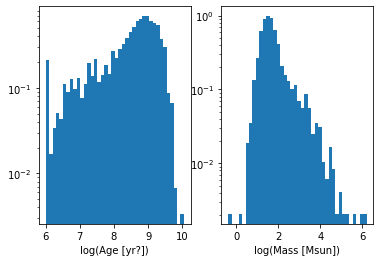

In [14]:
f,(ax1, ax2) = plt.subplots(1,2)

ax1.hist(logAge, bins=40, density=True)
ax1.set_xlabel('log(Age [yr?])')
ax1.set_yscale('log')

ax2.hist(logMass, bins=40, density=True)
ax2.set_xlabel('log(Mass [Msun])')
ax2.set_yscale('log')


### As if I'm only reading from the file

[5.12436104e-07]


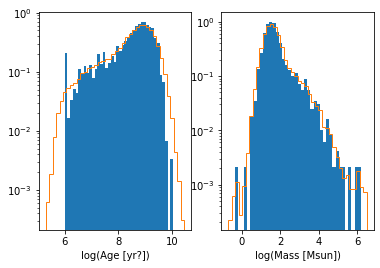

In [15]:
df = pd.read_csv("OCcompiled_hasAgeMass.csv")

data = np.vstack((df['logAge'].values, df['logMass'].values))
KDE = gaussian_kde(data)
sample = KDE.resample(size=int(1e5))

nbins = 40

f,(ax1, ax2) = plt.subplots(1,2)
ax1.hist(df['logAge'].values, bins=nbins, density=True)
ax1.hist(sample[0,:], bins=nbins, density=True, histtype='step')
ax1.set_xlabel('log(Age [yr?])')
ax1.set_yscale('log')

ax2.hist(df['logMass'].values, bins=nbins, density=True)
ax2.hist(sample[1,:], bins=nbins, density=True, histtype='step')
ax2.set_xlabel('log(Mass [Msun])')
ax2.set_yscale('log')

lt = 5
lm = 2
values = np.vstack([lt, lm])
print(KDE(values))
#NOTE: the age KDE seems to be missing the edges.  Maybe I should set those to zero automatically?

### Make a smaller file that has everything we need for the EBLSST code

Name, RA, Dec, dist[kpc], rh[pc], mass[Msun], Age[Myr], Z, sigma_v[km/s]

In [16]:
df = pd.read_csv("OCcompiled.csv")


name = []
RA = []
Dec = []

logMass = []
logAge = []
for index, row in df.iterrows():
    name.append(row['name'])
    
    #RA
    if (pd.notnull(row['ra'])):
        RA.append(row['ra'])
    elif (pd.notnull(row['RA_2000'])):
        RA.append(row['RA_2000'])
    else:
        print('NO RA', row['name'])
        #print('\nNO RA', row)
     
    #Dec
    Dec.append(row['dec'])
    
    #age
    if (pd.notnull(row['log_age'])): #MWSC
        logAge.append(row['log_age'])
    elif (pd.notnull(row['logt'])): #Solaris
        logAge.append(row['logt'])
    elif (pd.notnull(row['log(t[yr])K'])): #Kharchenko
        logAge.append(row['log(t[yr])K'])
    elif (pd.notnull(row['Age'])): #WEBDA
        logAge.append(np.log10(row['Age']))

print(len(name),len(RA))

NO RA Lynga_7
NO RA NGC_3324
NO RA Platais_3
NO RA Platais_9
NO RA Sigma_Ori
NO RA Berkeley_42
NO RA van_den_Bergh-Hagen_176
NO RA ESO092-SC18
NO RA ESO093-SC08
NO RA Hyades
3013 3003
